Todo:
1)year by year breakdown of florida code is runnning (needed to get the names of non deduped list since employee in multiple years)      

2)Need to clean up some charts...remove the first chart, add some state means from census

3) Department and titles some files have and some dont...lots of job titles...looksl like tedious work

4)for states w/ time series time trend

In [ ]:
from ethnicolr import census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name
import pandas as pd
from os import listdir
from os.path import isfile, join

root = '/Users/seunglee/Downloads/project/'


Run the Race Imputation

Unzip the .7z files to one directory...here it's "raw_data"

In [ ]:
import pandas as pd
from ethnicolr import census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name


root = '/Users/seunglee/Downloads/project/'


race_summary_not_wiki = pd.DataFrame()
race_summary_wiki = pd.DataFrame()
models = ['race_census_ln', 'race_pred_census_ln', 'race_pred_fl_reg_ln', 'race_pred_fl_reg_name']
onlyfiles=['state_1995_2014.csv', 'k12_1997_2014.csv', 'counties_1995_2014.csv', 'cities_1995_2014.csv', 'university_2014.csv',]

for f in onlyfiles:
    df_org = pd.read_csv(root+f)
    df = df_org.drop_duplicates(subset=['Employee Name'])
    df = df[['Employee Name']]
    
    df['ln'] = df['Employee Name'].str.split(',').str[0].str.lower()
    df['fn'] = df['Employee Name'].str.split(',').str[1].str.split(' ').str[1].str.strip()
    original_columns = list(df.columns)
    
    models_str = []
    for model in [census_ln, pred_census_ln, pred_fl_reg_ln, pred_fl_reg_name]:
        model_name = model.__name__
        models_str.append('race_'+model_name)
        if(model_name=='census_ln'): 
            df = model(df, 'ln')
            df.replace('(S)', '0', inplace=True)
            race_cols = df.columns[df.columns.str.startswith('pct')]
            for col in race_cols:
                df[col] = df[col].astype('double')
            df['race'] = df[race_cols].idxmax(axis=1)
        elif(model_name=='pred_wiki_name'):
            df = model(df, 'fn', 'ln')
        elif(model_name=='pred_fl_reg_name'):
            df = model(df, lname_col='ln', fname_col='fn')
        else:
            df = model(df, 'ln')
        
        df.rename(columns={'race':'race_'+model_name}, inplace=True) 
    
    df_org = df_org.merge(df, how='left', on=['Employee Name'])
    df_org.to_csv(root+'employee_race/data/'+f)
    print('done:', f)
    
#############################################################################

onlyfiles=['state_1995_2014.csv', 'k12_1997_2014.csv', 'counties_1995_2014.csv', 'cities_1995_2014.csv', 'university_2014.csv',]

for f in onlyfiles:
    df = pd.read_csv(root+'employee_race/data/'+f, index_col=[0])
    start_ind = pd.DataFrame(df.dtypes).reset_index()
    temp = start_ind.loc[start_ind['index']=='ln'].index[0]
    
    keep_cols1 = list(start_ind.loc[:temp-1, 'index'])
    keep_cols2 = list(df.columns[df.columns.str.startswith('race')])
    df2 = df[keep_cols1+keep_cols2]
    df2.to_csv(root+'employee_race/data/'+f.replace('.csv', '_all.csv'))



#############################################################################



Produces the csv files that have grouped salary and race composition over years

In [ ]:
def get_stats(df, df_description, name, year_begin=2014, year_end=2014, race='all', model='n/a'):
    print(name, year_begin, year_end, race, model)
    counter = df_description.shape[0]
    skip = 1
    try:
        df_prev = df_description.loc[
                (df_description.gov == name)&
                (df_description.year_period_start==year_begin)&
                (df_description.year_period_end==year_end)&(df_description.model=='n/a')].drop_duplicates(keep='last')
        
        n_observations = df_prev['n_observations'].values[0]
        n_uniq = df_prev['n_uniq_observations'].values[0]
        avg_salary = df_prev['salary_avg'].values[0]
        median_salary = df_prev['salary_median'].values[0]
        uniq_avg_salary = df_prev['uniq_salary_avg'].values[0]
        uniq_median_salary = df_prev['uniq_salary_median'].values[0]
    except:
        print('errror')
        skip = 0
        
    df_uniq = df.drop_duplicates(subset=['Employee Name'])
    df_description.loc[counter, 'gov'] = name
    df_description.loc[counter, 'year_period_start'] = year_begin
    df_description.loc[counter, 'year_period_end'] = year_end
    df_description.loc[counter, 'state'] = 'fl'
    df_description.loc[counter, 'race'] = race
    df_description.loc[counter, 'model'] = model

    df_description.loc[counter, 'n_observations'] = df.shape[0]  
    df_description.loc[counter, 'salary_avg'] = df[pay].mean()/1e3    
    df_description.loc[counter, 'salary_median'] = df[pay].median()/1e3
    df_description.loc[counter, 'salary_min'] = df[pay].min()/1e3
    df_description.loc[counter, 'salary_max'] = df[pay].max()/1e3
    df_description.loc[counter, 'salary_std'] = df[pay].std()/1e3   
    
    df_description.loc[counter, 'n_uniq_observations'] = df_uniq.shape[0]  
    df_description.loc[counter, 'uniq_salary_avg'] = df_uniq[pay].mean()/1e3    
    df_description.loc[counter, 'uniq_salary_median'] = df_uniq[pay].median()/1e3
    df_description.loc[counter, 'uniq_salary_min'] = df_uniq[pay].min()/1e3
    df_description.loc[counter, 'uniq_salary_max'] = df_uniq[pay].max()/1e3
    df_description.loc[counter, 'uniq_salary_std'] = df_uniq[pay].std()/1e3  
    
    if(skip>0):
        df_description.loc[counter, 'race_composition'] = df.shape[0]/n_observations
        df_description.loc[counter, 'race_composition_uniq'] = df_uniq.shape[0]/n_uniq
      
        df_description.loc[counter, 'ratio_avgRaceSalary_avgPopSalary'
                           ] =  df_description.loc[counter, 'salary_avg']/avg_salary 
        df_description.loc[counter, 'uniq_ratio_avgRaceSalary_avgPopSalary'
                           ] =  df_description.loc[counter, 'uniq_salary_avg']/uniq_avg_salary 
                           
        df_description.loc[counter, 'ratio_medianRaceSalary_medianPopSalary'
                           ] =  df_description.loc[counter, 'salary_median']/median_salary 
        df_description.loc[counter, 'uniq_ratio_medianRaceSalary_medianPopSalary'
                           ] =  df_description.loc[counter, 'uniq_salary_median']/uniq_median_salary 
    return df_description

    
 
pay_map = {'state':'Total Compensation', 'cities':'Salary', 'k12':'Salary', 'counties':'Salary', 'university':'Annual Salary'}
onlyfiles=['university_2014.csv', 'state_1995_2014_all.csv', 'k12_1997_2014_all.csv',
           'counties_1995_2014_all.csv', 'cities_1995_2014_all.csv']
models = ['race_census_ln', 'race_pred_census_ln', 'race_pred_fl_reg_ln', 'race_pred_fl_reg_name']

df_description = pd.DataFrame()
for f in onlyfiles:
    df = pd.read_csv(root+'employee_race/data/'+f)
    name = f.split('_')[0]
    pay = pay_map[name]
    year_def1 = f.split('_')[1].replace('.csv', '')
    try:
        year_def2 = f.split('_')[2].replace('.csv', '')
    except:
        year_def2 = year_def1
        
    if(df[pay].dtype=='O'):
        df[pay] = df[pay].str.replace('$', '')
        df[pay] = df[pay].str.replace(',', '')
        df[pay] = df[pay].astype('double')
    df = df.loc[df[pay]>0]
    get_stats(df, df_description, name, year_begin=year_def1, year_end=year_def2)
    
    for model in models:
        for race in ['white', 'hispanic', 'black', 'asian']:
            if(race=='asian'):    
                df_race = df.loc[(df[model].str.contains(race))|(df[model].str.contains('api'))]
            else:
                df_race = df.loc[(df[model].str.contains(race))&~(pd.isna(df[model]))]           
            get_stats(df_race, df_description, name, race=race, model=model,
                      year_begin=year_def1, year_end=year_def2)
            
            
    if('Year' in df.columns):
        for year in df.Year.unique():
            df_year = df.loc[df.Year==year]
            get_stats(df_year, df_description, name, year_begin=year, year_end=year)
            for model in models:
                for race in ['white', 'hispanic', 'black', 'asian']:
                    if(race=='asian'):    
                        df_race = df_year.loc[(df_year[model].str.contains(race))|(df_year[model].str.contains('api'))]
                    else:
                        df_race = df_year.loc[(df_year[model].str.contains(race))&~(pd.isna(df_year[model]))]           
                    get_stats(df_race, df_description, name, race=race, model=model,
                              year_begin=year, year_end=year)
         
    
df_description.to_csv(root+'employee_race/data/florida_stats.csv')


In [ ]:
df_description.sort_values(by=['gov', 'year'], inplace=True)
df_description.head()

## Plots

In [159]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

root = '/Users/seunglee/Downloads/project/'
df_description = pd.read_csv(root+'employee_race/data/florida_stats.csv')

df_all = df_description.drop_duplicates(['gov', 'race', 'model'])
df_all_gb = df_all.groupby(['gov', 'race']).mean()[['race_composition',
                          'race_composition_uniq']].reset_index()
asian = df_all_gb.loc[df_all_gb.race=='asian'].sort_values(by='gov')
hispanic = df_all_gb.loc[df_all_gb.race=='hispanic'].sort_values(by='gov')
black = df_all_gb.loc[df_all_gb.race=='black'].sort_values(by='gov')
white = df_all_gb.loc[df_all_gb.race=='white'].sort_values(by='gov')
x = np.arange(5)  
width = 0.35 
margin = 0.05
width = .2

state_white_nonhispanic = .535
state_white = .773
state_black = .169
state_asian = .03
state_hispanic = .261


Race Composition Plot not filtering on years

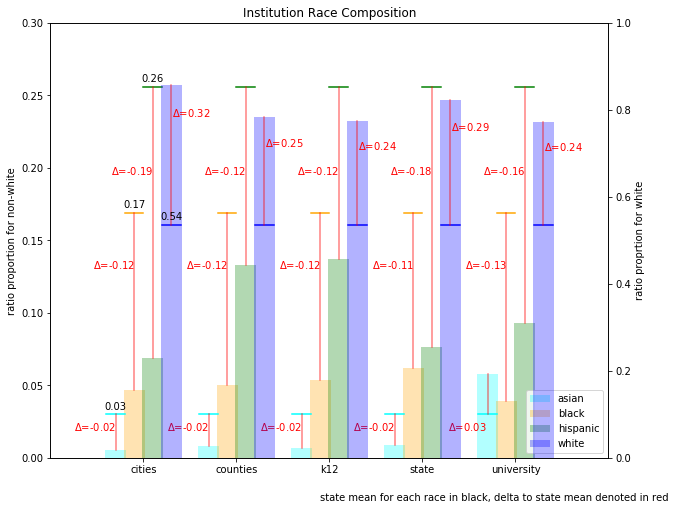

In [141]:

# Race Proportion
##############################################################
offset = 0
space = -.02
width2 = .2/6

state_asian = .03
state_black = .169
state_hispanic =.256
state_white = .535

colors = ['cyan', 'orange', 'green', 'blue']
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 8))    
asian1 = ax.bar(x -.3, asian.race_composition, width, alpha=.3, color='cyan')
black1 = ax.bar(x - .1, black.race_composition, width, alpha=.3, color='orange')
hispanic1 = ax.bar(x + .1, hispanic.race_composition, width, alpha=.3, color='green')
ax.set_ylim([0, .3])
ax.set_xlim([-1, 5])
ax1 = ax.twinx()
ax1.set_ylim([0, 1])
white1 = ax1.bar(x + .3, white.race_composition, width, alpha=.3, color='blue')
ax.set_ylabel('ratio proportion for non-white')
ax.set_title('Institution Race Composition')
ax.set_xticks(x)
ax.set_xticklabels(asian.gov)
ax1.set_ylabel('ratio proprtion for white')
#h1 = ax1.axhline(y = state_mean, xmin=width2*(3+i)+5*width2*j, xmax=width2*(4+i)+5*width2*j, color='red')
#v1 = ax1.axvline(x=-.3+.2*i+j, ymin=yMin, ymax=yMax, color='red')
#plt.show()

shapes=[asian1, black1, hispanic1, white1]
state_means = [state_asian, state_black, state_hispanic, state_white]
for i, shape in enumerate(shapes):
    for j, rect in enumerate(shape):
        height = rect.get_height()
        state_mean = state_means[i]
        yMax = max(height, state_mean)
        yMin = min(height, state_mean)
        if(i==3):
            h1 = ax1.axhline(y = state_mean, xmin=width2*(3+i)+5*width2*j, xmax=width2*(4+i)+5*width2*j, color=colors[i])
            v1 = ax1.axvline(x=-.3+.2*i+j, ymin=yMin, ymax=yMax, color='red', alpha=.5)
        else:
            h1 = ax.axhline(y = state_mean, xmin=width2*(3+i)+5*width2*j, xmax=width2*(4+i)+5*width2*j, color=colors[i])
            v1 = ax.axvline(x=-.3+.2*i+j, ymin=yMin/.3, ymax=yMax/.3, color='red', alpha=.5)
        if((j==0)&(i<3)):
            ax.annotate('{}'.format(round(state_mean,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, state_mean),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        if((j==0)&(i==3)):
            ax1.annotate('{}'.format(round(state_mean,2)),
                    xy=(rect.get_x() + rect.get_width() / 2, state_mean),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        if(i==0):
            ax.annotate(r'$\Delta$' + '={}'.format(round(height-state_mean,2)),
                    xy=(rect.get_x()-.075, state_mean-.5*state_mean),
                    xytext=(-3, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='red')            
        if((i<3)&(i>0)):
            ax.annotate(r'$\Delta$' + '={}'.format(round(height-state_mean,2)),
                    xy=(rect.get_x()-.075, state_mean-.25*state_mean),
                    xytext=(-3, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='red')
        if(i==3):
            ax1.annotate(r'$\Delta$' + '={}'.format(round(height-state_mean,2)),
                    xy=(rect.get_x() + 1.3*rect.get_width(), .9*height),
                    xytext=(3, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='red')                
ax.legend([asian1, black1, hispanic1, white1], ['asian', 'black', 'hispanic', 'white'], loc='lower right')
fig.text(.5, .05, 'state mean for each race in black, delta to state mean denoted in red')
plt.savefig(root+'statemean.png')
plt.show()


##############################################################

In [162]:

df_all['total_salary'] = df_all.n_observations * df_all.salary_avg

df_all_pay_gb = df_all.groupby(['gov', 'race']).sum()[['total_salary',
                          'n_observations']].reset_index()

df_all_pay_gb['avg_salary'] = df_all_pay_gb['total_salary']/df_all_pay_gb['n_observations']

df_all_pay_gb_median = df_all.groupby(['gov', 'race']).mean()[['salary_median']].reset_index()

asian_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='asian'].sort_values(by='gov')
hispanic_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='hispanic'].sort_values(by='gov')
black_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='black'].sort_values(by='gov')
white_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='white'].sort_values(by='gov')

df_all_pay_gb_median.head()


,gov,race,salary_median
0,cities,all,29.408930
1,cities,asian,35.080595
2,cities,black,25.536267
3,cities,hispanic,30.807481
4,cities,white,29.466094


Institution Pay

Text(0.5, 0.98, 'Salary by Instituion and Race (Mean of 4 race models)')

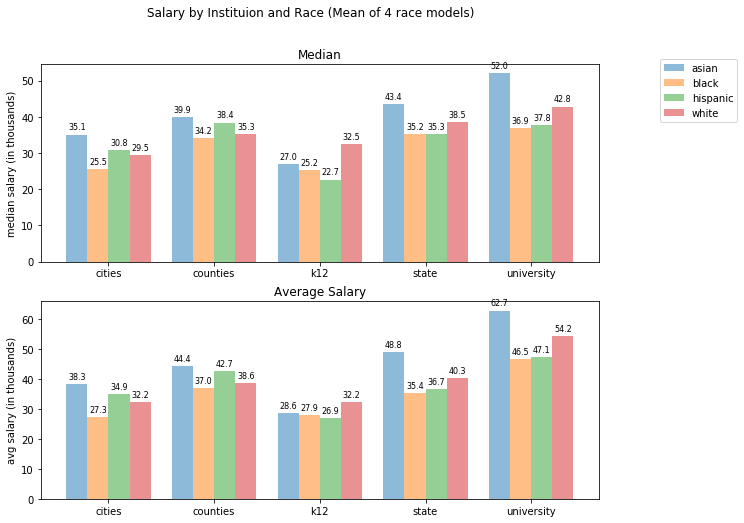

In [177]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax[axis].annotate('{}'.format(round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)
   
# Race Pay
##############################################################
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(10, 8))    
rect_asian = ax[0].bar(x - .3, df_all_pay_gb_median.loc[df_all_pay_gb.race=='asian', 'salary_median'],
          width, label='asian', alpha=.5)
rect_black = ax[0].bar(x - .1, df_all_pay_gb_median.loc[df_all_pay_gb.race=='black', 'salary_median'],
          width, label='black', alpha=.5)
rect_hispanic = ax[0].bar(x + .1, df_all_pay_gb_median.loc[df_all_pay_gb.race=='hispanic', 'salary_median'],
          width, label='hispanic', alpha=.5)
rect_white = ax[0].bar(x + .3, df_all_pay_gb_median.loc[df_all_pay_gb.race=='white', 'salary_median'],
          width, label='white', alpha=.5)
ax[0].set_ylabel('median salary (in thousands)')
ax[0].set_title('Median')
ax[0].set_xticks(x)
ax[0].set_xticklabels(asian.gov)
ax[0].legend(bbox_to_anchor=(1.1, 1.05))

autolabel(rect_asian,0)
autolabel(rect_black,0)
autolabel(rect_hispanic,0)
autolabel(rect_white,0)

rect_asian = ax[1].bar(x - .3, asian_pay.avg_salary, width, label='asian', alpha=.5)
rect_black = ax[1].bar(x - .1, black_pay.avg_salary, width, label='black', alpha=.5)
rect_hispanic = ax[1].bar(x + .1, hispanic_pay.avg_salary, width, label='hispanic', alpha=.5)
rect_white = ax[1].bar(x + .3, white_pay.avg_salary, width, label='white', alpha=.5)
ax[1].set_ylabel('avg salary (in thousands)')
ax[1].set_title('Average Salary')
ax[1].set_xticks(x)
ax[1].set_xticklabels(asian.gov)
ax[0].legend(bbox_to_anchor=(1.1, 1.05))

autolabel(rect_asian,1)
autolabel(rect_black,1)
autolabel(rect_hispanic,1)
autolabel(rect_white,1)

plt.suptitle('Salary by Instituion and Race (Mean of 4 race models)')
##############################################################



In [178]:
df_years = df_description.loc[df_description.year_period_start == df_description.year_period_end]
df_year_gb = df_years.groupby(['year_period_start', 'gov', 'race']).mean()[['race_composition',
                          'race_composition_uniq']].reset_index()
df_year_gb = df_year_gb.loc[df_year_gb.gov!='university']
df_year_gb['year'] = df_year_gb['year_period_start'].astype('int')
df_year_gb['log_composition'] = np.log(df_year_gb.race_composition)

asian = df_year_gb.loc[df_year_gb.race=='asian'].sort_values(by=['race', 'gov', 'year_period_start'])
hispanic = df_year_gb.loc[df_year_gb.race=='hispanic'].sort_values(by=['race', 'gov', 'year_period_start'])
black = df_year_gb.loc[df_year_gb.race=='black'].sort_values(by=['race', 'gov', 'year_period_start'])
white = df_year_gb.loc[df_year_gb.race=='white'].sort_values(by=['race', 'gov', 'year_period_start'])




Plot TS Race Composition

Text(0.5, 0.98, 'Race Composition Time Series by Race (Mean of 4 race models)')

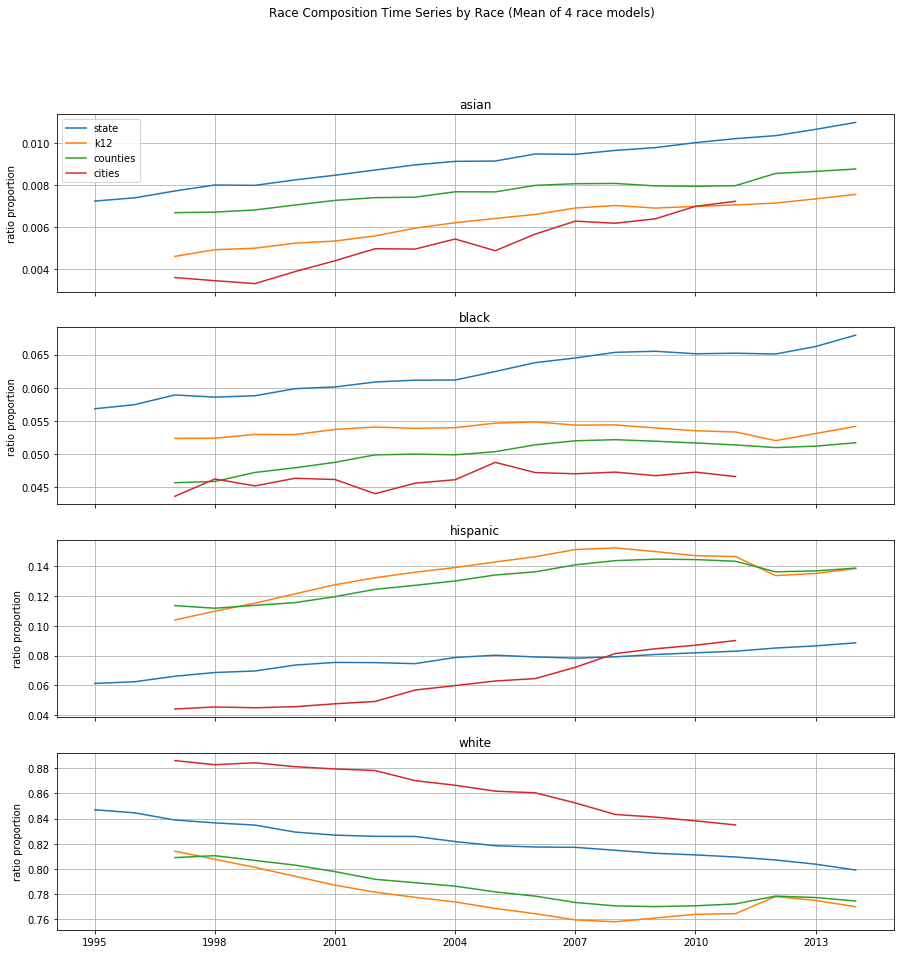

In [188]:
from matplotlib.ticker import MaxNLocator


# time series composition
##############################################################
plt.close('all')
fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True)    
ax[0].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'race_composition'], label='state')
ax[0].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'race_composition'], label='k12')
ax[0].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'race_composition'], label='counties')
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'race_composition'], label='cities')
ax[0].set_ylabel('ratio proportion')
ax[0].set_title('asian')
ax[0].grid()
ax[0].legend(loc='best')

ax[1].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'race_composition'], label='state')
ax[1].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'race_composition'], label='k12')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'race_composition'], label='counties')
ax[1].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'race_composition'], label='cities')
ax[1].set_ylabel('ratio proportion')
ax[1].set_title('black')
ax[1].grid()

ax[2].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'race_composition'], label='state')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'race_composition'], label='k12')
ax[2].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'race_composition'], label='counties')
ax[2].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'race_composition'], label='cities')
ax[2].set_ylabel('ratio proportion')
ax[2].set_title('hispanic')
ax[2].grid()
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[3].plot(white.loc[white.gov=='state', 'year'], white.loc[white.gov=='state', 'race_composition'], label='state')
ax[3].plot(white.loc[white.gov=='k12', 'year'], white.loc[white.gov=='k12', 'race_composition'], label='k12')
ax[3].plot(white.loc[white.gov=='counties', 'year'], white.loc[white.gov=='counties', 'race_composition'], label='counties')
ax[3].plot(white.loc[white.gov=='cities', 'year'], white.loc[white.gov=='cities', 'race_composition'], label='cities')
ax[3].set_ylabel('ratio proportion')
ax[3].set_title('white')
ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[3].grid()
plt.suptitle('Race Composition Time Series by Race (Mean of 4 race models)')
##############################################################


In [200]:
df_years['total_salary'] = df_years.n_observations * df_years.salary_avg
df_years_pay_gb = df_years.groupby(['year_period_start', 'gov', 'race']).sum()[['total_salary',
                          'n_observations']].reset_index()
df_years_pay_gb['year'] = df_years_pay_gb['year_period_start'].astype('int')
df_years_pay_gb['avg_salary'] = df_years_pay_gb['total_salary']/df_years_pay_gb['n_observations']

asian = df_years_pay_gb.loc[df_years_pay_gb.race=='asian'].sort_values(by=['gov', 'year'])
hispanic = df_years_pay_gb.loc[df_years_pay_gb.race=='hispanic'].sort_values(by=['gov', 'year'])
black = df_years_pay_gb.loc[df_years_pay_gb.race=='black'].sort_values(by=['gov', 'year'])
white = df_years_pay_gb.loc[df_years_pay_gb.race=='white'].sort_values(by=['gov', 'year'])
population = df_years_pay_gb.loc[df_years_pay_gb.race=='all'].sort_values(by=['gov', 'year'])

df_years_pay_gb_median = df_years.groupby(['year_period_start', 'gov', 'race']).mean()[['salary_median']].reset_index()



In [202]:
df_years_pay_gb_median.head()

,year_period_start,gov,race,salary_median
0,1995,state,all,26.637990
1,1995,state,asian,29.055222
2,1995,state,black,24.269390
3,1995,state,hispanic,24.352605
4,1995,state,white,26.854291


In [213]:
df_years_pay_gb_median.rename(columns={'year_period_start':'year', 'salary_median':'median_salary'}, inplace=True)
asian_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='asian']
black_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='black']
hispanic_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='hispanic']
white_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='white']


Median Salary TS

Text(0.5, 0.98, 'Median Salary Time Series by Race (Mean of 4 race models)')

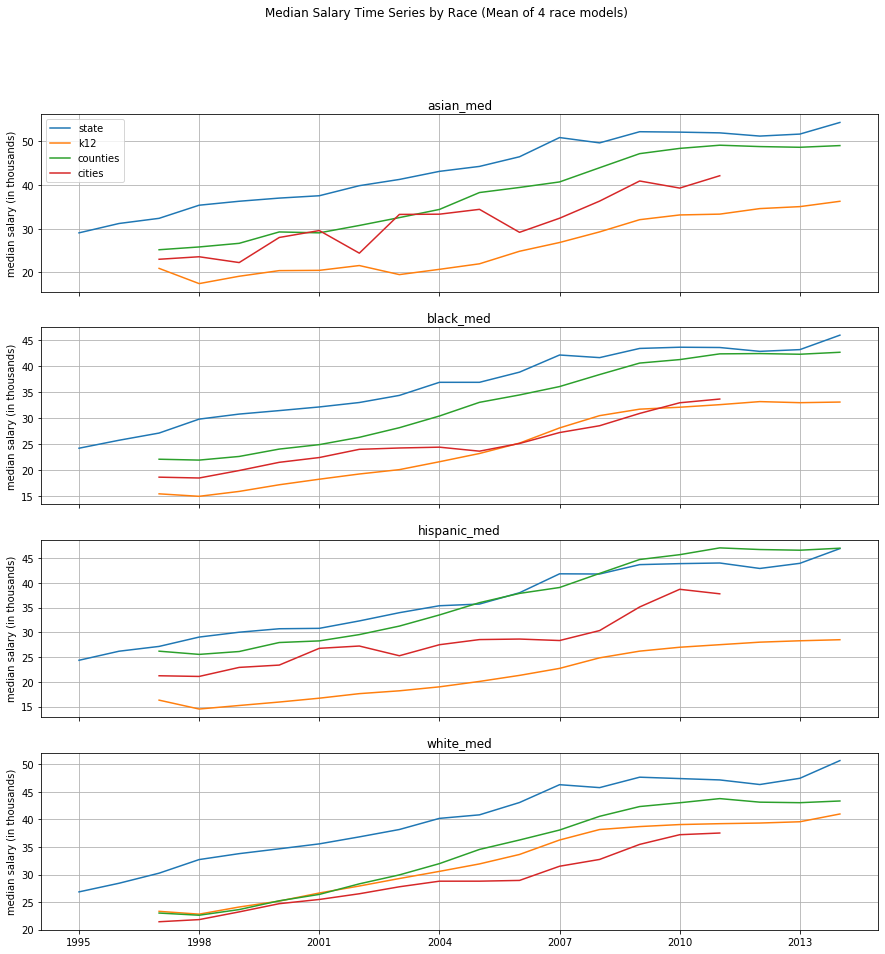

In [214]:

# time series pay
##############################################################
plt.close('all')
fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True)    
ax[0].plot(asian_med.loc[asian_med.gov=='state', 'year'], asian_med.loc[asian_med.gov=='state', 'median_salary'], label='state')
ax[0].plot(asian_med.loc[asian_med.gov=='k12', 'year'], asian_med.loc[asian_med.gov=='k12', 'median_salary'], label='k12')
ax[0].plot(asian_med.loc[asian_med.gov=='counties', 'year'], asian_med.loc[asian_med.gov=='counties', 'median_salary'], label='counties')
ax[0].plot(asian_med.loc[asian_med.gov=='cities', 'year'], asian_med.loc[asian_med.gov=='cities', 'median_salary'], label='cities')
ax[0].set_ylabel('median salary (in thousands)')
ax[0].set_title('asian_med')
ax[0].legend()
ax[0].grid()

ax[1].plot(black_med.loc[black_med.gov=='state', 'year'], black_med.loc[black_med.gov=='state', 'median_salary'], label='state')
ax[1].plot(black_med.loc[black_med.gov=='k12', 'year'], black_med.loc[black_med.gov=='k12', 'median_salary'], label='k12')
ax[1].plot(black_med.loc[black_med.gov=='counties', 'year'], black_med.loc[black_med.gov=='counties', 'median_salary'], label='counties')
ax[1].plot(black_med.loc[black_med.gov=='cities', 'year'], black_med.loc[black_med.gov=='cities', 'median_salary'], label='cities')
ax[1].set_ylabel('median salary (in thousands)')
ax[1].set_title('black_med')
ax[1].grid()

ax[2].plot(hispanic_med.loc[hispanic_med.gov=='state', 'year'], hispanic_med.loc[hispanic_med.gov=='state', 'median_salary'], label='state')
ax[2].plot(hispanic_med.loc[hispanic_med.gov=='k12', 'year'], hispanic_med.loc[hispanic_med.gov=='k12', 'median_salary'], label='k12')
ax[2].plot(hispanic_med.loc[hispanic_med.gov=='counties', 'year'], hispanic_med.loc[hispanic_med.gov=='counties', 'median_salary'], label='counties')
ax[2].plot(hispanic_med.loc[hispanic_med.gov=='cities', 'year'], hispanic_med.loc[hispanic_med.gov=='cities', 'median_salary'], label='cities')
ax[2].set_ylabel('median salary (in thousands)')
ax[2].set_title('hispanic_med')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].grid()

ax[3].plot(white_med.loc[white_med.gov=='state', 'year'], white_med.loc[white_med.gov=='state', 'median_salary'], label='state')
ax[3].plot(white_med.loc[white_med.gov=='k12', 'year'], white_med.loc[white_med.gov=='k12', 'median_salary'], label='k12')
ax[3].plot(white_med.loc[white_med.gov=='counties', 'year'], white_med.loc[white_med.gov=='counties', 'median_salary'], label='counties')
ax[3].plot(white_med.loc[white_med.gov=='cities', 'year'], white_med.loc[white_med.gov=='cities', 'median_salary'], label='cities')
ax[3].set_ylabel('median salary (in thousands)')
ax[3].set_title('white_med')
ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[3].grid()

plt.suptitle('Median Salary Time Series by Race (Mean of 4 race models)')
##############################################################




Average Salary Time Series

Text(0.5, 0.98, 'Average Salary Time Series by Race (Mean of 4 race models)')

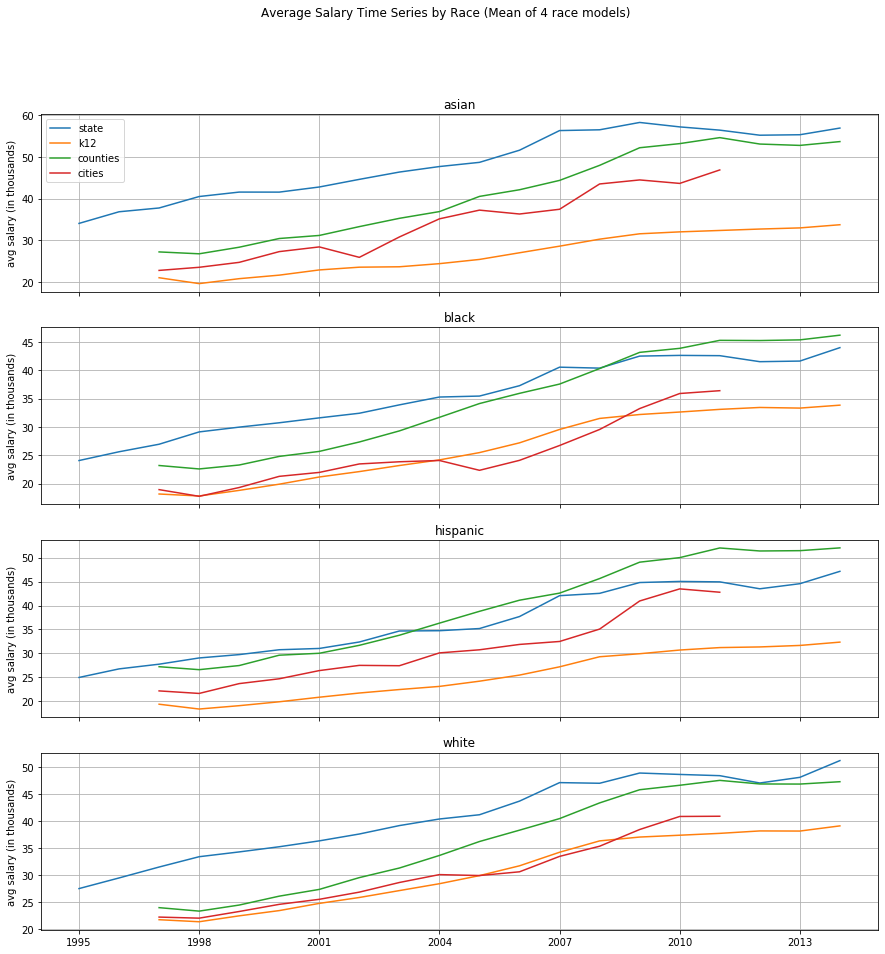

In [198]:


# time series pay
##############################################################
plt.close('all')
fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True)    
ax[0].plot(asian.loc[asian.gov=='state', 'year'], asian.loc[asian.gov=='state', 'avg_salary'], label='state')
ax[0].plot(asian.loc[asian.gov=='k12', 'year'], asian.loc[asian.gov=='k12', 'avg_salary'], label='k12')
ax[0].plot(asian.loc[asian.gov=='counties', 'year'], asian.loc[asian.gov=='counties', 'avg_salary'], label='counties')
ax[0].plot(asian.loc[asian.gov=='cities', 'year'], asian.loc[asian.gov=='cities', 'avg_salary'], label='cities')
ax[0].set_ylabel('avg salary (in thousands)')
ax[0].set_title('asian')
ax[0].legend()
ax[0].grid()

ax[1].plot(black.loc[black.gov=='state', 'year'], black.loc[black.gov=='state', 'avg_salary'], label='state')
ax[1].plot(black.loc[black.gov=='k12', 'year'], black.loc[black.gov=='k12', 'avg_salary'], label='k12')
ax[1].plot(black.loc[black.gov=='counties', 'year'], black.loc[black.gov=='counties', 'avg_salary'], label='counties')
ax[1].plot(black.loc[black.gov=='cities', 'year'], black.loc[black.gov=='cities', 'avg_salary'], label='cities')
ax[1].set_ylabel('avg salary (in thousands)')
ax[1].set_title('black')
ax[1].grid()

ax[2].plot(hispanic.loc[hispanic.gov=='state', 'year'], hispanic.loc[hispanic.gov=='state', 'avg_salary'], label='state')
ax[2].plot(hispanic.loc[hispanic.gov=='k12', 'year'], hispanic.loc[hispanic.gov=='k12', 'avg_salary'], label='k12')
ax[2].plot(hispanic.loc[hispanic.gov=='counties', 'year'], hispanic.loc[hispanic.gov=='counties', 'avg_salary'], label='counties')
ax[2].plot(hispanic.loc[hispanic.gov=='cities', 'year'], hispanic.loc[hispanic.gov=='cities', 'avg_salary'], label='cities')
ax[2].set_ylabel('avg salary (in thousands)')
ax[2].set_title('hispanic')
ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[2].grid()

ax[3].plot(white.loc[white.gov=='state', 'year'], white.loc[white.gov=='state', 'avg_salary'], label='state')
ax[3].plot(white.loc[white.gov=='k12', 'year'], white.loc[white.gov=='k12', 'avg_salary'], label='k12')
ax[3].plot(white.loc[white.gov=='counties', 'year'], white.loc[white.gov=='counties', 'avg_salary'], label='counties')
ax[3].plot(white.loc[white.gov=='cities', 'year'], white.loc[white.gov=='cities', 'avg_salary'], label='cities')
ax[3].set_ylabel('avg salary (in thousands)')
ax[3].set_title('white')
ax[3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[3].grid()

plt.suptitle('Average Salary Time Series by Race (Mean of 4 race models)')
##############################################################




State mean from 2010 census.
https://en.wikipedia.org/wiki/Demographics_of_Florida